In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import MigPreFuncoes
import SlantStack
from tqdm import tqdm

In [2]:
importlib.reload(MigPreFuncoes)
importlib.reload(SlantStack)

<module 'SlantStack' from 'C:\\Users\\guilh\\Desktop\\Code\\SeismicDiffractions\\SlantStack.py'>

*****

# Velvector com pontos difratores

*****

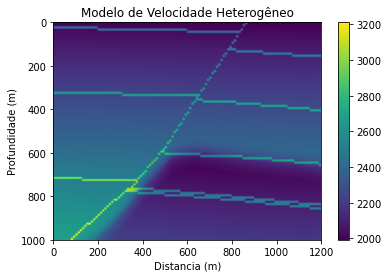

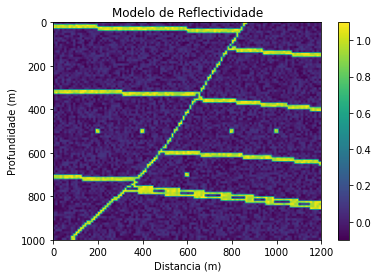

In [3]:
fr=40
nps=200
dt=.005 
rick=MigPreFuncoes.ricker(nps,fr,dt)

sx=10  #index position
sz=0  #index position
nx=120
ntr=120
nz=100
dt=.005
dx=10  #meters
dz=10  #meters
c=1992 #velocidade m/s

tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))

nd2=nt+1; 
W=np.zeros(2*nt);
W[nt:nt+nps-1]=rick[0:nps-1];
x=np.arange(0,nx)
z=np.arange(0,nz)

velvector1 = np.loadtxt("Data/velvector") # Modelo de velocidade - 1 coluna em ASCII
vel = np.reshape(velvector1,[201,501]) # Coloca na dimensão correta
vel1 = vel[40:140,240:360] # Recorta um pequeno pedaço do modelovel[40:140,250:360]

c=vel1.min()
tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))

nd2=nt+1; 
W=np.zeros(2*nt);
W[nt:nt+nps-1]=rick[0:nps-1];
SW = 1./vel1 # Modelo de vagarosidade

plt.imshow(vel1,aspect="auto",extent=[0,nx*dx,dz*nz,0])
plt.colorbar()
plt.title("Modelo de Velocidade Heterogêneo")
plt.xlabel("Distancia (m)")
plt.ylabel("Profundidade (m)")
plt.show()


dvel1=(np.abs(np.diff(vel1,axis=0)));
mx=np.max(dvel1.flatten('F'));  # Compute Refl Model for vel1;
dvel1=dvel1/mx;
dvel1=np.round(dvel1);
dvv=dvel1[nz-2,:]
R=np.append(dvel1,dvv[np.newaxis],axis=0);   # We lost a row in R by diff() so we add it back again

#Adding diff points
R[50-1:50+1,20-1:20+1] = 1 
R[50-1:50+1,40-1:40+1] = 1 
R[50-1:50+1,80-1:80+1] = 1 
R[50-1:50+1,100-1:100+1] = 1 
R[70-1:70+1,60-1:60+1] = 1 

#Adicionando ruído no modelo
nn = np.random.rand(nz,nx)
R = R+(nn-0.5)*0.2

plt.imshow(R, extent=[0, nx*dx, nz*dz, 0], aspect='auto')
plt.title("Modelo de Reflectividade")
plt.xlabel("Distancia (m)")
plt.ylabel("Profundidade (m)")
plt.colorbar()
plt.show()

In [4]:
with open("Data/CSG/velvector2_model", "wb") as f: 
    np.save(f, R)

In [5]:
#TT = MigPreFuncoes.raymodel3(SW,dx,ntr,"Data/CSG/raiosVelvector2.npy")

In [6]:
with open("Data/CSG/raiosVelvector2.npy", 'rb') as f:
    TTh = np.load(f)
    
timer=np.round(TTh/dt)+1

In [7]:
#Creating the synthetic csg

dsx = 5 #talvez dê bug na hora de abrir os files usando esse dsx != 1, preciso testar isso!!!
nsx = nx
ngx = nx

#files = MigPreFuncoes.kirchhoffModeling(nsx,ngx,dsx,nx,nt,dt,TTh,R,W,"Data/CSG/Diff_velvector2")

In [8]:
files = []

for i in range(0,nsx,dsx):
    filename = "Data/CSG/Diff_velvector2_{}".format(i)
    with open(filename, 'rb') as file:
        (gather) = np.load(file)
        files.append(gather)

In [9]:
pmin = -2
pmax = 2
dp = 0.1
xwin=zwin = 30
x_ini=z_ini = 0

#pm,sm = SlantStack.local_window(R,xwin,zwin,x_ini,z_ini,dx,dz,pmin,pmax,dp) 
#
#with open("Data/CSG/Diff_velvector2_dipfield", "wb") as f: 
#    np.save(f, pm)
#    
#with open("Data/CSG/Diff_velvector2_semblance", "wb") as f: 
#    np.save(f, sm)

with open("Data/CSG/Diff_velvector2_dipfield", "rb") as f:
    pm = np.load(f)

with open("Data/CSG/Diff_velvector2_semblance", "rb") as f:
    sm = np.load(f)

In [10]:
m_theta = np.arctan(pm)

X = np.sin(m_theta)
Y = np.cos(m_theta)

In [11]:
import importlib
importlib.reload(MigPreFuncoes)
importlib.reload(SlantStack)

<module 'SlantStack' from 'C:\\Users\\guilh\\Desktop\\Code\\SeismicDiffractions\\SlantStack.py'>

In [12]:
shot = 60

file_original = 'Data/CSG/Diff_velvector2_{}'.format(int(shot))

with open(file_original, 'rb') as file:
    gather1t = np.load(file)

gather1=gather1t[0:nt,:]
isx=shot

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:09<00:00, 12.49it/s]


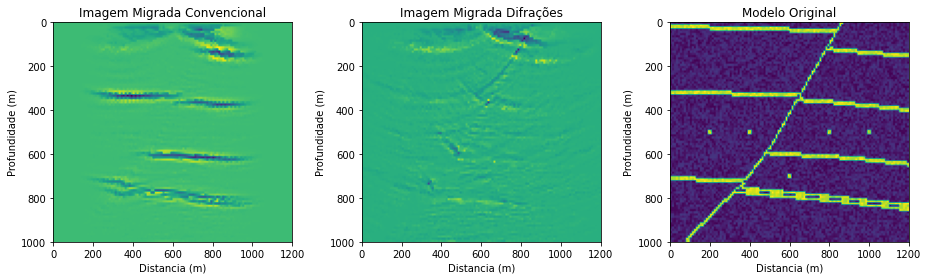

In [14]:
dwin=dt
win=10*dt #(metade) janela em tempo em cada etapa
app_ref=20 # abertura reflexões
app_dif=50 # abertura difrações

refl,diff = MigPreFuncoes.migration_teste(gather1,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(refl, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Imagem Migrada Difrações")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Modelo Original")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

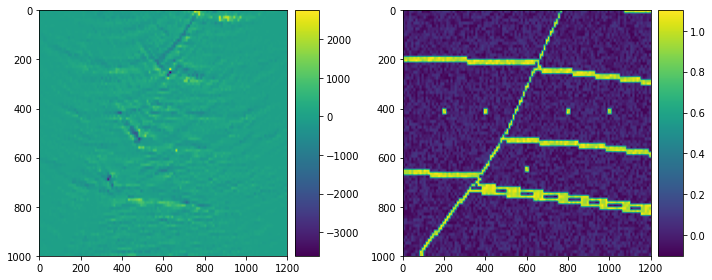

In [15]:
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(diff[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
im2 = ax2.imshow(R[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [18]:
with open("Data/vv_mig_refl", "wb") as f: 
    np.save(f, refl_stackteste)
    
with open("Data/vv_mig_diff", "wb") as f: 
    np.save(f, diff_stackteste)

24it [03:34,  8.95s/it]


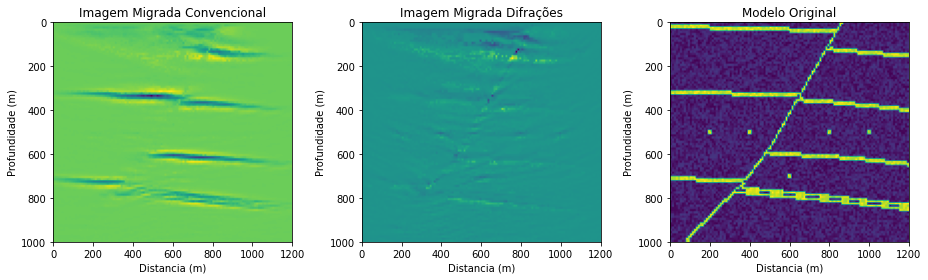

In [16]:
refl_stackteste,diff_stackteste = MigPreFuncoes.migration_teste(files,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(refl_stackteste, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff_stackteste, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Imagem Migrada Difrações")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Modelo Original")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

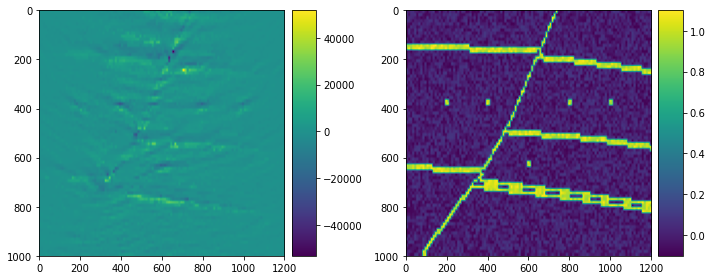

In [17]:
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(diff_stackteste[20:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])#,interpolation="nearest")
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
im2 = ax2.imshow(R[20:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [ ]:
refl_stackteste,diff_stackteste = MigPreFuncoes.migration_teste(files,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(refl_stackteste, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff_stackteste, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Imagem Migrada Difrações")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Modelo Original")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(diff_stackteste[20:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])#,interpolation="nearest")
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
im2 = ax2.imshow(R[20:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

testando $w = (1-w)^2$

24it [03:41,  9.22s/it]


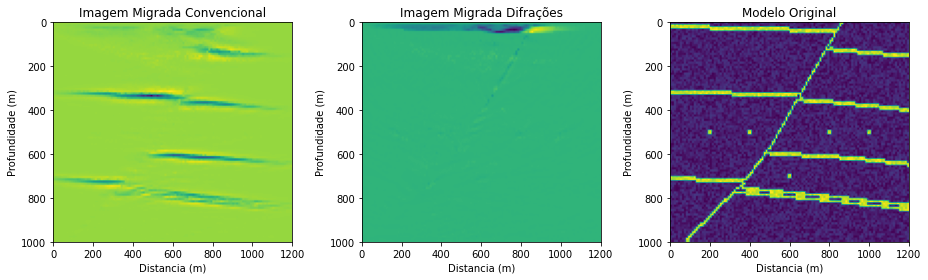

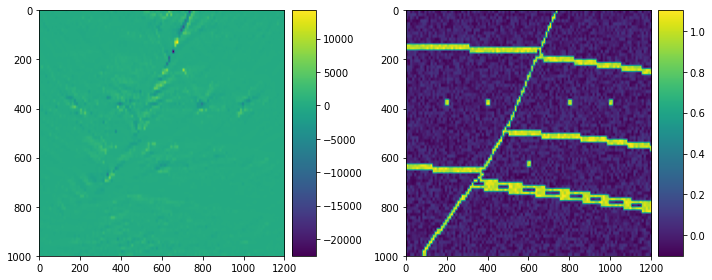

In [19]:
refl_stackteste,diff_stackteste = MigPreFuncoes.migration_teste(files,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(refl_stackteste, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff_stackteste, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Imagem Migrada Difrações")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Modelo Original")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(diff_stackteste[20:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])#,interpolation="nearest")
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
im2 = ax2.imshow(R[20:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [15]:
igx=isx=60

In [76]:
w_60 = MigPreFuncoes.peso(TTh, dt, X, Y, igx, isx)
wd_60 = (1-np.abs(w_60))**2
wd_60_2 = (1-np.abs(w_60)**2)

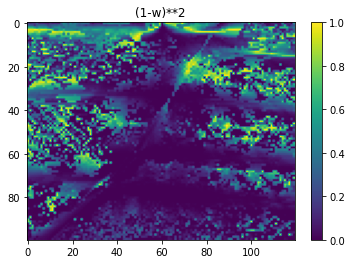

In [79]:
plt.imshow(wd_60,aspect="auto")
plt.title("(1-w)**2")
plt.colorbar()
plt.show()

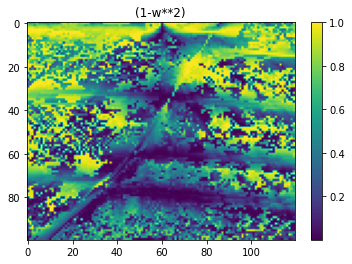

In [80]:
plt.imshow(wd_60_2,aspect="auto")
plt.title("(1-w**2)")
plt.colorbar()
plt.show()

100%|████████████████████████████████████████████████████████████████████████████████| 120/120 [00:09<00:00, 12.44it/s]


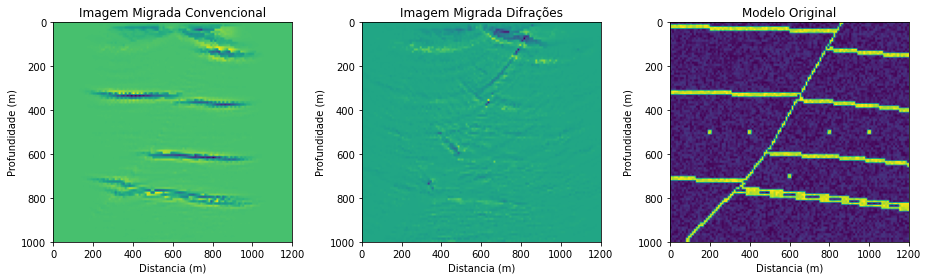

In [70]:
dwin=dt
win=10*dt #(metade) janela em tempo em cada etapa
app_ref=20 # abertura reflexões
app_dif=50 # abertura difrações

import importlib
importlib.reload(MigPreFuncoes)
importlib.reload(SlantStack)

refl,diff = MigPreFuncoes.migration_teste(gather1,isx,dx,dz,dt,win,dwin,app_ref,app_dif,TTh,X,Y,sm)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(refl, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Imagem Migrada Difrações")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Modelo Original")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

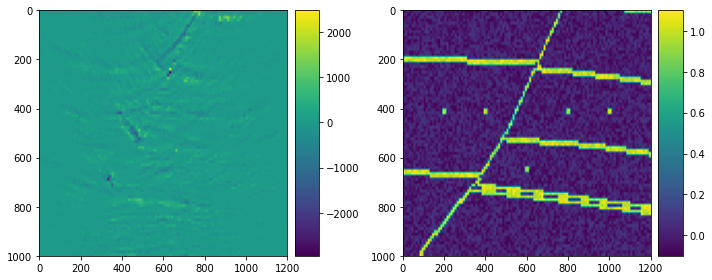

In [69]:
fig = plt.figure(figsize=(10,4))

ax1 = fig.add_subplot(121)
im1 = ax1.imshow(diff[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
im2 = ax2.imshow(R[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

*****

# Velvector Original

*****

In [ ]:
fr=40
nps=200
dt=.005 
rick=MigPreFuncoes.ricker(nps,fr,dt)

sx=10  #index position
sz=0  #index position
nx=110
nz=100
dt=.005
dx=10  #meters
dz=10  #meters
c=1992 #velocidade m/s

tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))

nd2=nt+1; 
W=np.zeros(2*nt);
W[nt:nt+nps-1]=rick[0:nps-1];
x=np.arange(0,nx)
z=np.arange(0,nz)

In [ ]:
plt.figure(figsize=(5,4))
plt.plot(W[280:340], "k", linewidth=0.9, alpha=0.8)
plt.title("Wavelet Utilizada nas Modelagens (Ricker)")
plt.ylabel("Amplitude")
plt.xlabel("Tempo (s)")
plt.show()

In [ ]:
velvector1 = np.loadtxt("Data/velvector") # Modelo de velocidade - 1 coluna em ASCII
vel = np.reshape(velvector1,[201,501]) # Coloca na dimensão correta
vel1 = vel[40:140,250:360] # Recorta um pequeno pedaço do modelovel[40:140,250:360]

c=vel1.min()

tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))

nd2=nt+1; 
W=np.zeros(2*nt);
W[nt:nt+nps-1]=rick[0:nps-1];
SW = 1./vel1 # Modelo de vagarosidade

In [ ]:
vel1_disturbed = vel1 + 150
SW_errado = 1./vel1_disturbed

In [ ]:
plt.imshow(vel1,extent=[0,nx*dx,dz*nz,0],aspect="auto")
plt.colorbar()
plt.title("Modelo de Velocidade Heterogêneo")
plt.xlabel("Distancia (m)")
plt.ylabel("Profundidade (m)")
plt.show()

plt.imshow(vel1_disturbed,extent=[0,nx*dx,dz*nz,0],aspect="auto")
plt.colorbar()
plt.title("Modelo de Velocidade Heterogêneo ERRADO")
plt.xlabel("Distancia (m)")
plt.ylabel("Profundidade (m)")
plt.show()

In [ ]:
SW = 1./vel[39:139,249:359]

dvel1=(np.abs(np.diff(vel1,axis=0)));
mx=np.max(dvel1.flatten('F'));  # Compute Refl Model for vel1;
dvel1=dvel1/mx;
dvel1=np.round(dvel1);
dvv=dvel1[nz-2,:]
R=np.append(dvel1,dvv[np.newaxis],axis=0);   # We lost a row in R by diff() so we add it back again

#Adicionando ruído no modelo
nn = np.random.rand(nz,nx)
R = R+(nn-0.5)*0.2

plt.imshow(R, extent=[0, nx*dx, nz*dz, 0], aspect='auto')
plt.title("Modelo de Reflectividade")
plt.xlabel("Distancia (m)")
plt.ylabel("Profundidade (m)")
plt.colorbar()
plt.show()

In [ ]:
## Essa linha só precisa ser rodada uma vez,
#quando mudamos o modelo de vagarosidade (SW)

#Armazenamos a TT no file.npy, acessado na próxima célula.

In [ ]:
#TT=MigPreFuncoes.raymodel3(SW,dx,nx,'Data/CSG/raiosVelvector.npy') #Compute traveltime tables TTh(ixsrc,0:nz,0:n)

In [ ]:
#TT_errado=MigPreFuncoes.raymodel3(SW_errado,dx,nx,'Data/CSG/raiosVelvector_errado.npy')

In [ ]:
with open("Data/CSG/raiosVelvector_errado.npy", 'rb') as f:
    TTh_errado = np.load(f)
    
timer_errado=np.round(TTh_errado/dt)+1

In [ ]:
with open("Data/CSG/raiosVelvector.npy", 'rb') as f:
    TTh = np.load(f)
    
timer=np.round(TTh/dt)+1

In [ ]:
#TSX = (TTh[60,:,:])  # Traveltime 
#
#plt.imshow(TSX,extent=[0, nx*dx, nz*dz, 0], aspect='auto')
#plt.title("Tabela do Tempo de Trânsito")
#plt.xlabel("Distancia (m)")
#plt.ylabel("Profundidade (m)")
#plt.colorbar()
#plt.show()

In [ ]:
#Creating the synthetic csg

dsx = 5 
nsx = nx
ngx = nx

#files = MigPreFuncoes.kirchhoffModeling(nsx,ngx,dsx,nx,nt,dt,TTh,R,W,"Data/CSG/velvector_gather_shot")

In [ ]:
files = []

for i in range(0,nsx,dsx):
    filename = "Data/CSG/velvector_gather_shot_{}".format(i)
    with open(filename, 'rb') as file:
        (gather) = np.load(file)
        files.append(gather)

In [ ]:
G2=MigPreFuncoes.phase_shift(files[5])

plt.imshow(G2,aspect='auto',extent=[0, nx*dx, nt*dt, 0])
plt.xlabel('Distancia (m)')
plt.ylabel('Tempo (s)')
plt.show()

********

## Slant Stack

********

In [ ]:
pmin = -2
pmax = 2
dp = 0.1
xwin=zwin=30
x_ini=z_ini=0

In [ ]:
#pm,sm = SlantStack.local_window(R,xwin,zwin,x_ini,z_ini,dx,dz,pmin,pmax,dp) 
#
#with open("Data/CSG/velvector_dipfield", "wb") as f: 
#    np.save(f, pm)
#    
#with open("Data/CSG/velvector_semblance", "wb") as f: 
#    np.save(f, sm)

In [ ]:
with open("Data/CSG/velvector_dipfield", "rb") as f:
    pm = np.load(f)

with open("Data/CSG/velvector_semblance", "rb") as f:
    sm = np.load(f)
    
fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(121)
ax1.set_title("Ângulos pmax (em tangente)")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")
im1 = ax1.imshow(pm,extent=[0, nx*dx, nz*dz, 0])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
ax2.set_title("Semblance")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")
im2 = ax2.imshow(sm,extent=[0, nx*dx, nz*dz, 0])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [ ]:
m_theta = np.arctan(pm)

X = np.sin(m_theta)
Y = np.cos(m_theta)

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(121)
ax1.set_title("Componente X")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")
im1 = ax1.imshow(X)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
ax2.set_title("Componente Y")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")
im2 = ax2.imshow(Y)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [ ]:
win=20*dt #(metade) janela em tempo em cada etapa
dwin=dt
app=20 # abertura em traços

shot = 60
filename = 'Data/CSG/velvector_gather_shot_{}'.format(int(shot))

with open(filename, 'rb') as file:
    gather1t = np.load(file)

print(nt)
gather1=gather1t[0:nt,:]
isx=shot

**********

# Migração

**********

In [ ]:
importlib.reload(MigPreFuncoes)
importlib.reload(SlantStack)

In [ ]:
refl,diff = MigPreFuncoes.kirchhoffMigration(gather1,isx,dx,dz,dt,win,dwin,app,TTh,X,Y)

### Single Shot, Peso = w

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(refl, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Imagem Migrada Difrações")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Modelo Original")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
refl_er,diff_er = MigPreFuncoes.kirchhoffMigration(gather1,isx,dx,dz,dt,win,dwin,app,TTh_errado,X,Y)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(refl_er, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional - 150 m/s a mais")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff_er, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Imagem Migrada Difrações - 150 m/s a mais")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Modelo Original")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
plt.imshow(refl, aspect="auto",extent=[0,dx*nx,dz*nz,0])
plt.colorbar()
plt.show()

plt.imshow(refl_er, aspect="auto",extent=[0,dx*nx,dz*nz,0])
plt.colorbar()
plt.show()

In [ ]:
plt.imshow(diff[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
plt.colorbar()
plt.show()

plt.imshow(diff_er[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
plt.colorbar()
plt.show()

plt.imshow(R[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
plt.show()

### Single Shot, Peso Alterado

In [ ]:
importlib.reload(MigPreFuncoes)

win=20*dt #(metade) janela em tempo em cada etapa
dwin=dt
app=20 # abertura em traços

refl,diff = MigPreFuncoes.migration_teste(gather1,isx,dx,dz,dt,win,dwin,app,TTh,X,Y,sm)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(refl, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Imagem Migrada Difrações")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Modelo Original")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
plt.imshow(diff[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
plt.show()

plt.imshow(R[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
plt.show()

*********

### Stack

*********

In [ ]:
refl_stack,diff_stack = MigPreFuncoes.kirchhoffMigration(files,isx,dx,dz,dt,win,dwin,app,TTh,X,Y)

### Multiple Shots, Peso = w

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(refl_stack, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional (Stack)")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff_stack, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Imagem Migrada Difrações (Stack)")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Modelo Original")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
plt.imshow(diff_stack[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
plt.show()

plt.imshow(R[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
plt.show()

### Multiple Shots, Peso Alterado

In [ ]:
importlib.reload(MigPreFuncoes)

win=20*dt #(metade) janela em tempo em cada etapa
dwin=dt
app=20 # abertura em traços

refl_stackteste,diff_stackteste = MigPreFuncoes.migration_teste(files,isx,dx,dz,dt,win,dwin,app,TTh,X,Y,sm)

fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(refl_stackteste, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff_stackteste, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Imagem Migrada Difrações")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Modelo Original")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
plt.imshow(diff_stackteste[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
plt.show()

plt.imshow(R[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
plt.show()

### Comparando as imagens de difração stack com peso original e com peso alterado

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(diff_stack[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Peso = w")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff_stackteste[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Peso = w**4")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(R[15:,:], aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Modelo Original")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(13,4))

ax1.imshow(diff_stack, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Peso = w")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(diff_stackteste, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Peso = w**4")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

ax3.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax3.set_title("Modelo Original")
ax3.set_xlabel("Distancia (m)")
ax3.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
        ###################
        ###### TESTE ######
        ###################

velvector1 = np.loadtxt("Data/velvector") 
vel = np.reshape(velvector1,[201,501])

plt.imshow(vel,aspect="auto")
plt.show()

vel1 = vel[65:165,370:480]

plt.imshow(vel1,aspect="auto")
plt.show()

vel2 = vel[40:140,250:360]

plt.imshow(vel2,aspect="auto")
plt.show()

********

******

*********

## Modelo 2 

In [ ]:
#Esse modelo é só um teste que eu estava mexendo, pode ignorar!

In [ ]:
dx=1.0 #(m) Discretização em X
dz=1.0 #(m) Discretização em Y
nz=120 #Tamanho do Grid em Z
ntr=nx=240 #Tamanho do Grid em X
c=250 #m/s

In [ ]:
MOD = np.zeros([ntr,nz])

#Barra
x_ini_1 = int(np.round(1*ntr/9))
x_fim_1 = int(np.round(4*ntr/9))

x_ini_2 = int(np.round(4*ntr/9))
x_fim_2 = int(np.round(5*ntr/9))

x_ini_3 = int(np.round(5*ntr/9))
x_fim_3 = int(np.round(8*ntr/9))

#Horizontal
for i in range(x_ini_1,x_fim_1):
    z = int(np.round(nz*3/9))
    MOD[i,z]=1
    
z_ini = int(np.round(nz*3/9))
z_fim = int(np.round(nz*5/9))

#Falha 
xaxis = np.arange(107,133)
yaxis = np.arange(41,67)
for i in range(len(xaxis)):
    xs,ys = xaxis[i],yaxis[i]
    MOD[xs,ys]=1

#Horizontal    
for i in range(x_ini_3,x_fim_3):
    z = int(np.round(nz*5/9))
    MOD[i,z]=1
    
#Pontos Difratores
#MOD[int(np.round(2.5*nx/9)):int(np.round(2.5*nx/9+3)),z_ini]=3
#MOD[int(np.round(6.5*nx/9)):int(np.round(6.5*nx/9+3)),z_fim]=3

#Adicionando ruído no modelo
nn = np.random.rand(ntr,nz)
MOD = MOD+(nn-0.5)*0.2

R = MOD.T

plt.imshow(MOD.T, aspect="auto", extent=[0,dx*ntr,nz*dz,0])
plt.colorbar()
plt.show()

 Detectando as inclinações presentes no modelo
pmin=-3
pmax=3
dp=0.1

S,pmaxS,taumaxS,smax,ip,itau = SlantStack.slant_stack(pmin,pmax,dp,0,nz*dz,dz,MOD.T,dx,dz,0,0)

plt.imshow(S,extent=[pmin,pmax,nz*dz,0],aspect="auto")
plt.colorbar()
plt.xlabel('p')
plt.ylabel('tau')
plt.show()

In [ ]:
#Modelo de Vagarosidade
SW=np.ones([nz,ntr])*1/c

In [ ]:
with open('Data/time_table_barra.npy', 'rb') as f:
    TTh = np.load(f)

dt=0.004

TSX = (TTh[120,:,:])  # Traveltime  (indexes)
plt.imshow(TSX,extent=[0, ntr*dx, nz*dz, 0], aspect='auto')
plt.colorbar()
plt.show()

timer=np.round(TTh/dt)+1

In [ ]:
#Wavelet

fr=40 #Hz
nps=200 #era 200, mudei pra 136 e funcionou, 
#       #tenho que conferir se posso fazer isso mesmo...
dt=.004 #s
rick=MigPreFuncoes.ricker(nps,fr,dt)

#sx=10  #index position
#sz=0  #index position

# Tempo de ida e volta até o fundo do modelo
tmax = np.sqrt((dx*nx)**2+(dz*nz)**2)*2/c
nt=int(np.ceil(tmax/dt+1))
print(tmax)
#nd2=nt+1; 



W=np.zeros(2*nt);
W[nt:nt+nps-1]=rick[0:nps-1]


plt.plot(np.arange(-nt*dt,nt*dt,dt),W)
plt.xlabel('s')

In [ ]:
#Creating the synthetic csg

dsx = 1
nsx = nx
ngx = nx
path = "Data/CSG/fault_gather_shot"

#files = MigPreFuncoes.kirchoffModeling(nsx,ngx,dsx,nx,nt,dt,TTh,R,W,path)

In [ ]:
files = []

for i in range(240):
    filename = 'Data/CSG/fault_gather_shot_{}'.format(i)
    #print(i,filename)
    with open(filename, 'rb') as file:
        (gather) = np.load(file)
        files.append(gather)

In [ ]:
shot = 120
filename = 'Data/CSG/fault_gather_shot_{}'.format(int(shot))

with open(filename, 'rb') as file:
    gather1t = np.load(file)

print(nt)
gather1=gather1t[0:nt,:]
win=20*dt
dwin=dt
app=15
isx=shot


plt.imshow(gather1,aspect='auto',extent=[0, nx*dx, nt*dt, 0])
plt.ylim([1,0])
plt.xlabel('Distancia (m)')
plt.ylabel('Tempo (s)')
plt.show()

In [ ]:
pmin = -1.5
pmax = 1.5
dp = 0.1
xwin=zwin=30
dx=dz=1
x_ini=z_ini=0

#pm,sm = SlantStack_v2.local_window(R,xwin,zwin,x_ini,z_ini,dx,dz,pmin,pmax,dp)

#with open("Data/CSG_diffbar/dip_field_fault", "wb") as f:
#    np.save(f,pm)

In [ ]:
with open("Data/CSG_diffbar/dip_field_fault", "rb") as f:
    tst = np.load(f)


fig = plt.figure(figsize=(10, 12))

ax1 = fig.add_subplot(121)
ax1.set_title("Ângulos pmax (em tangente)")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")
im1 = ax1.imshow(tst,extent=[0, nx*dx, nz*dz, 0])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
ax2.set_title("Semblance")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")
im2 = ax2.imshow(sm,extent=[0, nx*dx, nz*dz, 0])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [ ]:
m_theta = np.arctan(tst)
plt.imshow(m_theta,extent=[0, ntr*dx, nz*dz, 0], aspect="auto")
plt.title("Ângulos em graus")
plt.colorbar()
plt.show()

In [ ]:
X = np.sin(m_theta)
Y = np.cos(m_theta)

fig = plt.figure(figsize=(10, 10))

ax1 = fig.add_subplot(121)
ax1.set_title("Componente X")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")
im1 = ax1.imshow(X)
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im1, cax=cax, orientation='vertical')


ax2 = fig.add_subplot(122)
ax2.set_title("Componente Y")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")
im2 = ax2.imshow(Y)
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='10%', pad=0.1)
fig.colorbar(im2, cax=cax, orientation='vertical')

plt.tight_layout()
plt.show()

In [ ]:
for i in range(110,130):
    isx=igx=i

    w = MigPreFuncoes.peso(TTh,dt,X,Y,i,i)

    plt.imshow(w, aspect="auto")
    plt.show()

In [ ]:
#import importlib
#import MigPreFuncoes
#importlib.reload(MigPreFuncoes)

print(dx,dz)
win=10*dt #(metade)janela em tempo em cada etapa
dwin=dt
epsilon = 0.1

app=40 # abertura em traços

#print(isx,dx,dz,dt,win,dwin,app)
#print('gather shape is ', gather.shape)
#print('TTh shape is ', TTh.shape)
epsilon=1.0  # frequency dependent


mig_winapp = MigPreFuncoes.migvsp_winapp(gather1,isx,dx,dz,dt,
                                         win,dwin,app,TTh,X,Y, epsilon)


fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_winapp, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Convencional")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
mig_diff = MigPreFuncoes.migvsp_winapp_diff(gather1,isx,dx,dz,dt,win,dwin,app,TTh,X,Y,epsilon)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada Difração")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

## Stack

In [ ]:
mig_stack = MigPreFuncoes.migstack_winapp(files,isx,dx,dz,dt,win,dwin,app,TTh,X,Y,epsilon)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_stack, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
mig_stack_diff = MigPreFuncoes.migstack_winapp_diff(files,isx,dx,dz,dt,win,dwin,app,TTh,X,Y,epsilon)

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,4))

ax1.imshow(mig_stack_diff, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax1.set_title("Imagem Migrada")
ax1.set_xlabel("Distancia (m)")
ax1.set_ylabel("Profundidade (m)")

ax2.imshow(R, aspect="auto",extent=[0,dx*nx,dz*nz,0])
ax2.set_title("Modelo Original")
ax2.set_xlabel("Distancia (m)")
ax2.set_ylabel("Profundidade (m)")

plt.tight_layout()
plt.show()

In [ ]:
plt.imshow(refl_stackteste, aspect="auto",extent=[0,dx*nx,dz*nz,0],cmap="Greys")
plt.title("Imagem Migrada Convencional")
plt.xlabel("Distancia (m)")
plt.ylabel("Profundidade (m)")
plt.show()

plt.imshow(diff_stackteste, aspect="auto",extent=[0,dx*nx,dz*nz,0],cmap="Greys")
plt.title("Imagem Migrada Convencional")
plt.xlabel("Distancia (m)")
plt.ylabel("Profundidade (m)")
plt.show()